The objective of this challenge is to develop a machine learning model to assess if a Twitter post related to vaccinations is positive, neutral, or negative. This solution could help governments and other public health actors monitor public sentiment towards COVID-19 vaccinations and help improve public health policy, vaccine communication strategies, and vaccination programs across the world.

# Setting up environment 


In [0]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import mean_squared_error as mse, r2_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
import warnings

warnings.filterwarnings("ignore")

In [0]:
seed = 3
random.seed(seed)
np.random.seed(seed)

# Reading data

In [0]:
train = pd.read_csv("Train.csv")
test = pd.read_csv("Test.csv")

In [4]:
train.head()

,tweet_id,safe_text,label,agreement
0,CL1KWCMY,Me &amp; The Big Homie meanboy3000 #MEANBOY #M...,0.0,1.0
1,E3303EME,I'm 100% thinking of devoting my career to pro...,1.0,1.0
2,M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE Y...",-1.0,1.0
3,1DR6ROZ4,I mean if they immunize my kid with something ...,-1.0,1.0
4,J77ENIIE,Thanks to <user> Catch me performing at La Nui...,0.0,1.0


We'll need to clean the *safe_text* to remove **hashtags** and **<user>** elements.

# Simple EDA

We'll begin by doing some simple data exploration, just to get an idea about the dataset.

In [5]:
print(train.shape)
print(test.shape)

(10001, 4)
(5177, 2)


In [6]:
train.describe()

,label,agreement
count,10000.000000,9999.000000
mean,0.301567,0.854252
std,0.646718,0.180707
min,-1.000000,0.333333
25%,0.000000,0.666667
50%,0.000000,1.000000
75%,1.000000,1.000000
max,1.000000,1.000000


Let's check null rows

In [7]:
train.isna().sum()

tweet_id     0
safe_text    0
label        1
agreement    2
dtype: int64

In [8]:
train[train.isna().any(axis=1)]

,tweet_id,safe_text,label,agreement
4798,RQMQ0L2A,#lawandorderSVU,NaN,NaN
4799,I cannot believe in this day and age some pare...,1,0.666667,NaN


In [9]:
test.isna().sum()

tweet_id     0
safe_text    1
dtype: int64

In [10]:
test[test.isna().any(axis=1)]

,tweet_id,safe_text
2024,Dr. JAMES SHANNON,NaN


We'll need to replace/remove those rows!

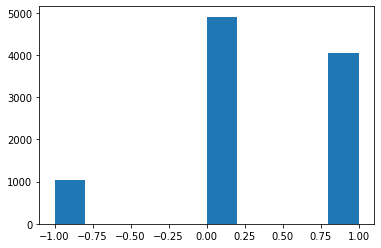

In [11]:
_ = plt.hist(train.label)

Maybe we'll need to use data augmentation or to specify class weights!

153


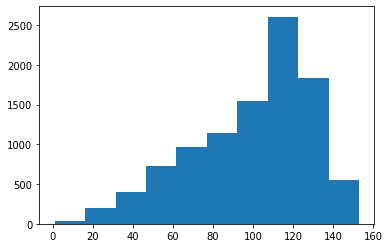

In [12]:
train_text_len = [len(row.safe_text) for _, row in train.iterrows()]
max_train_len = max(train_text_len)
print(max_train_len)
_ = plt.hist(train_text_len)

# Data preprocessing

Let's start by replacing missing values

In [0]:
train.agreement[4799],train.label[4799], train.safe_text[4799], = train.label[4799], train.safe_text[4799], train.tweet_id[4799]
train.label.loc[4798], train.agreement.loc[4798] = 0, 0

test.fillna(" ", inplace=True)

Now we need to clean the *safe_text* feature

In [0]:
def clean_text(text):
    # Remove <user> tags
    text = re.sub(r'<.*?>', '', text)

    # Replace &amp; with 'and'
    text = re.sub(r"&amp;", "and", text)  
    
    # Replace punctuation characters with spaces
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
    translate_dict = dict((c, " ") for c in filters)
    translate_map = str.maketrans(translate_dict)
    text = text.translate(translate_map)

    # Convert text to lowercase
    text = text.strip().lower()

    return text

In [0]:
train.safe_text = train.safe_text.map(lambda text: clean_text(text))
test.safe_text = test.safe_text.map(lambda text: clean_text(text))

In [16]:
train.head()

,tweet_id,safe_text,label,agreement
0,CL1KWCMY,me and the big homie meanboy3000 meanboy mb ...,0.0,1.0
1,E3303EME,i'm 100 thinking of devoting my career to pro...,1.0,1.0
2,M4IVFSMS,whatcausesautism vaccines do not vaccinate yo...,-1.0,1.0
3,1DR6ROZ4,i mean if they immunize my kid with something ...,-1.0,1.0
4,J77ENIIE,thanks to catch me performing at la nuit nyc ...,0.0,1.0


# Training

Spliting train data into training and validation sets

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(
    train.safe_text, train.label, stratify=train.label, random_state=42, test_size=0.2, shuffle=True)

## TfidfVectorizer + LogisticRegression

We'll be using CountVectorizer to tokenize the *safe_label* feature documents and build a vocabulary of known words. We'll use 3-gram to produce richer word sequences.

In [0]:
# Always start with these features. They work (almost) everytime!
tfv = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

# Fitting TF-IDF to both training and test sets (semi-supervised learning)
tfv.fit(list(X_train) + list(X_valid))
X_train_ctv =  tfv.transform(X_train) 
X_valid_ctv = tfv.transform(X_valid)
X_test_ctv = tfv.transform(test.safe_text)

Setting up a Stratified KFold.

(a nice article about Stratification https://medium.com/@xzz201920/stratifiedkfold-v-s-kfold-v-s-stratifiedshufflesplit-ffcae5bfdf)

In [0]:
n_folds = 10
fold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)
total_score = 0
test_predictions_probas = []

In [20]:
for i, (train_indices,val_indices) in enumerate(fold.split(X_train_ctv, y_train)):
    # Building the subsets
    sub_X_train,sub_y_train = X_train_ctv[train_indices], np.take(y_train, train_indices, axis=0)
    sub_X_val,sub_y_val = X_train_ctv[val_indices], np.take(y_train, val_indices, axis=0)

    # Training the model
    model = LogisticRegression(C=1, penalty='l2')
    model.fit(sub_X_train, sub_y_train)

    # Calculation RMSE score on validation set
    val_predictions_proba = model.predict_proba(sub_X_val)
    # Shifting the probability
    val_prediction = [(pred.argmax()-1)*pred[pred.argmax()] 
                      for pred in val_predictions_proba]
    score = np.sqrt(mse(sub_y_val, val_prediction))
    print("Fold {}: {}".format(i, score))
    total_score += score
    
    # Predicting probabilities using the current model
    test_prediction = model.predict_proba(X_test_ctv)
    test_predictions_probas.append(test_prediction)

print("Average score: {}".format(total_score/n_folds))

Fold 0: 0.6151477140865876
Fold 1: 0.5863152666094198
Fold 2: 0.6093283524514201
Fold 3: 0.5801592749613679
Fold 4: 0.5859679267453084
Fold 5: 0.6061070079603144
Fold 6: 0.5801463682779356
Fold 7: 0.5891978969220586
Fold 8: 0.5699230395427929
Fold 9: 0.5728020478730914
Average score: 0.5895094895430297


## TfidfVectorizer + MultinomialNB

Setting up a Stratified KFold.

(a nice article about Stratification https://medium.com/@xzz201920/stratifiedkfold-v-s-kfold-v-s-stratifiedshufflesplit-ffcae5bfdf)

In [0]:
n_folds = 10
fold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)
total_score = 0
test_predictions_probas = []

In [22]:
for i, (train_indices,val_indices) in enumerate(fold.split(X_train_ctv, y_train)):
    # Building the subsets
    sub_X_train,sub_y_train = X_train_ctv[train_indices], np.take(y_train, train_indices, axis=0)
    sub_X_val,sub_y_val = X_train_ctv[val_indices], np.take(y_train, val_indices, axis=0)

    # Training the model
    model = MultinomialNB()
    model.fit(sub_X_train, sub_y_train)

    # Calculation RMSE score on validation set
    val_predictions_proba = model.predict_proba(sub_X_val)
    # Shifting the probability
    val_prediction = [(pred.argmax()-1)*pred[pred.argmax()] 
                      for pred in val_predictions_proba]
    score = np.sqrt(mse(sub_y_val, val_prediction))
    print("Fold {}: {}".format(i, score))
    total_score += score
    
    # Predicting probabilities using the current model
    test_prediction = model.predict_proba(X_test_ctv)
    test_predictions_probas.append(test_prediction)

print("Average score: {}".format(total_score/n_folds))

Fold 0: 0.6252855567118889
Fold 1: 0.6046131141808099
Fold 2: 0.6179936416095242
Fold 3: 0.6048798911775579
Fold 4: 0.6114428077537346
Fold 5: 0.6144795156199503
Fold 6: 0.5955535923431698
Fold 7: 0.597896469501498
Fold 8: 0.5998275296276155
Fold 9: 0.6073272816187302
Average score: 0.6079299400144479


## CountVectorize + LogisticRegression

We'll be using CountVectorizer to tokenize the *safe_label* feature documents and build a vocabulary of known words. We'll use 3-gram to produce richer word sequences.

In [0]:
ctv = CountVectorizer(analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), stop_words = 'english')

# Fitting Count Vectorizer to both training and test sets (semi-supervised learning)
ctv.fit(list(X_train) + list(X_valid))
X_train_ctv =  ctv.transform(X_train) 
X_valid_ctv = ctv.transform(X_valid)
X_test_ctv = ctv.transform(test.safe_text)

Setting up a Stratified KFold.

(a nice article about Stratification https://medium.com/@xzz201920/stratifiedkfold-v-s-kfold-v-s-stratifiedshufflesplit-ffcae5bfdf)

In [0]:
n_folds = 10
fold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)
total_score = 0
test_predictions_probas = []

In [25]:
for i, (train_indices,val_indices) in enumerate(fold.split(X_train_ctv, y_train)):
    # Building the subsets
    sub_X_train,sub_y_train = X_train_ctv[train_indices], np.take(y_train, train_indices, axis=0)
    sub_X_val,sub_y_val = X_train_ctv[val_indices], np.take(y_train, val_indices, axis=0)

    # Training the model
    model = LogisticRegression(C=1, penalty='l2')
    model.fit(sub_X_train, sub_y_train)

    # Calculation RMSE score on validation set
    val_predictions_proba = model.predict_proba(sub_X_val)
    # Shifting the probability
    val_prediction = [(pred.argmax()-1)*pred[pred.argmax()] 
                      for pred in val_predictions_proba]
    score = np.sqrt(mse(sub_y_val, val_prediction))
    print("Fold {}: {}".format(i, score))
    total_score += score
    
    # Predicting probabilities using the current model
    test_prediction = model.predict_proba(X_test_ctv)
    test_predictions_probas.append(test_prediction)

print("Average score: {}".format(total_score/n_folds))

Fold 0: 0.647525951470175
Fold 1: 0.5948758422411301
Fold 2: 0.6058983006406948
Fold 3: 0.5709592588434641
Fold 4: 0.5887080271915054
Fold 5: 0.6229951478882324
Fold 6: 0.6109321521966157
Fold 7: 0.5914233920244131
Fold 8: 0.576120978238763
Fold 9: 0.5779065929246101
Average score: 0.5987345643659604


# Submission

In [0]:
test_prediction_proba = np.mean(test_predictions_probas, axis=0)
# Converting the probability into its corresponding class
test_prediction = [(pred.argmax()-1)*pred[pred.argmax()] 
                  for pred in test_prediction_proba]

In [0]:
submission = pd.DataFrame({"tweet_id":test.tweet_id, "label":test_prediction})
submission.to_csv("submission.csv", index=False)